In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F

import json
import re

import numpy as np
import itertools
from collections import Counter, defaultdict

from tqdm import tqdm_notebook


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install pymorphy2[fast]
# !pip3 install gensim
# !pip3 install torchtext
# !pip3 install emoji


In [3]:
!ls ../data

BbrqRksHkTN.json	    lenta-texts-small-val.json
agentgirl.json		    lenta-texts-small.json
anastasia.hm.json	    lenta-texts.json
anastasiya_golovinova.json  mariakakdela.json
boyechik.json		    mem-train.json
buzova.json		    mem-val.json
cc.ru.300.bin		    mem.json
ekaterinakoba.json	    mem2.json
face_morphing.ipynb.json    mem_big.json
funastacia.json		    mem_smol.json
joined-emoji-train.json     mem_with_likes.json
joined-emoji-val.json	    navalny.json
joined-emoji.json	    ntv.json
joined.json		    portnyagin.json
karinakross.json	    ruwiki_20180420_100d.txt
katusha_adushkina.json	    savchuk.json
klavacoca.json		    sofia_stuzhuk.json
klyukina.json		    tvrain.json
lenta-ru-news.csv


In [4]:
import random

texts = []

for file in tqdm_notebook(['savchuk.json', 'funastacia.json',
                           'anastasia.hm.json', 'mem_big.json',
                           'klavacoca.json', 'karinakross.json', 'buzova.json',
                           'agentgirl.json', 'klyukina.json',
                           'katusha_adushkina.json', 'mariakakdela.json',
                           'BbrqRksHkTN.json', 'sofia_stuzhuk.json',
                           'anastasiya_golovinova.json', 'ekaterinakoba.json']):
    with open('../data/' + file, 'r') as f:
        temp_file = json.load(f)
        for text in temp_file:
            texts.append({'text' : text['text']})
print(len(texts))
random.shuffle(texts)
with open('../data/joined-emoji-val.json', 'w') as f:
    json.dump(texts[:500], f)
    
with open('../data/joined-emoji-train.json', 'w') as f:
    json.dump(texts[500:], f)


39928


In [5]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def normal_form(word):
    return morph.parse(word)[0].normal_form

In [6]:
import emoji

def find_emoji(text):
    emojis = []
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            emojis.append(character)
    return emojis

def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI


In [7]:
def preprocess(text):
    return ' '.join([normal_form(i) for i in re.findall(r'[А-я]+', text) if len(i) > 2])

In [8]:
import torchtext.vocab as vocab

vectors = vocab.Vectors('../data/ruwiki_20180420_100d.txt') # file created by gensim


In [9]:
PAD_IDX = len(vectors.stoi) - 2
UNK_IDX = len(vectors.stoi) - 1
TOTAL_EMBS = len(vectors)

In [10]:
def vectorize_text_only(text):
    try:
        text = preprocess(text['text'])
    except TypeError as e:
        return None
    inds = []
    if len(text.split()) < 3:
        return None
    for word in text.split():
        try:
            inds.append(vectors.stoi[word])
        except KeyError:
            inds.append(UNK_IDX)
    if len(inds) < 2:
        return None
    while len(inds) < 90:
        inds.append(PAD_IDX)
    return inds[:90]


In [11]:
def vectorize(text):
    emojis = find_emoji(text['text'])
    if len(emojis) == 0:
        return None, None
    try:
        text = preprocess(text['text'])
    except TypeError as e:
        return None, None
    inds = []
    if len(text.split()) < 3:
        return None, None
    for word in text.split():
        try:
            inds.append(vectors.stoi[word])
        except KeyError:
            inds.append(UNK_IDX)
    if len(inds) < 2:
        return None, None
    while len(inds) < 90:
        inds.append(PAD_IDX)
    return inds[:90], emojis

In [12]:
def vectorize_all(texts):
    ans = []
    emojis = []
    for text in tqdm_notebook(texts):
        try:
            vec, ems = vectorize(text)
        except Exception as e:
            continue
        if vec:
            ans.append(vec)
            emojis.append(ems)
    return ans, emojis

In [13]:
with open('../data/joined-emoji-train.json', 'r') as f:
    cosmo = json.load(f)
cosmo, emojis = vectorize_all(cosmo)


In [14]:
# e2num = Counter(itertools.chain.from_iterable(emojis))
# e2i = defaultdict(lambda:632)
# c = 0
# for ind, e in enumerate(e2num):
#     if e2num[e[0]] > 3:
#         e2i[e[0]] = c
#         c+=1
#     else:
#         print(e, end=' ')

# i2e = defaultdict(lambda:'❓')
# for e, i in e2i.items():
#     i2e[i] = e


In [15]:
e2num = Counter(itertools.chain.from_iterable(emojis))
e2i = {}
c = 0
for ind, e in enumerate(e2num):
    if e2num[e[0]] > 10:
        e2i[e[0]] = c
        c+=1
    else:
        print(e, end=' ')

i2e = {}
for e, i in e2i.items():
    i2e[i] = e


🍢 😗 🐫 🏵 🌗 🛷 🕞 🐓 🔖 🚈 ⛩ 🦇 🏭 🗒 🇿 🌂 🏳 🧗 👢 🧾 🧑 🕸 🚐 🔳 📇 🚃 🏇 🐪 📣 🤮 🎍 🔧 🛣 🐩 ⛺ 🎏 🧣 🥙 🏴 ⚪ 🎲 🍠 🌜 🤬 🖍 🎻 🦌 🚆 🚉 ☯ 🕰 🚜 📅 🃏 🕐 🎰 🙎 🌓 ✒ 🧔 🤠 🦓 🚒 🥦 🏕 🕍 🌩 🎫 👡 💿 🍈 🥚 🆗 🧤 🗨 🆘 🐁 📆 🔑 🖇 📀 ⏯ 🧂 🧞 🥖 🛵 🌕 🦷 🐚 ☂ 🤝 🔌 🗡 🦈 🥜 🦂 🧵 🎽 🐊 🐮 🧹 ⤵ 🐜 🚰 🐖 🥩 🥵 🚌 🧷 🚅 🇾 🕉 🥼 🌦 ◀ 🔂 🌆 🥀 🤥 🚔 👝 🦕 🛰 🐺 🥋 🦛 🧴 🏚 🦎 🔗 🕓 🔨 📐 ⛓ 🌵 🐏 🏣 📮 🗝 🧩 📛 🎮 🧶 ↗ 🏪 🛶 ⏳ 🥢 🎛 🥬 🌔 🦞 🛌 🦑 🆓 🔁 🛋 📧 🇰 🧁 ◽ 🇴 🔀 🔎 🐄 🛡 ⛏ 🍞 🖌 💲 🌋 📈 👔 🍵 🤹 🔚 🔋 🏓 🎱 📟 🎷 🌛 🔵 🤾 🔃 🕙 🚼 ⬛ ♾ 🎠 🤲 🔷 🦍 💾 🐛 🦹 🚣 📼 😦 👤 ✏ 🚑 🐗 🗳 ™ 🤡 🤛 🦚 🌖 ♨ ✴ 🐀 🚵 🔒 🛒 🚷 ❕ 🥫 😾 💒 ⬅ 🔰 👴 Ⓜ ⛴ 📳 🚪 🐲 🖋 📉 🚹 📰 🛎 💺 🇻 🏢 🥕 🚺 📻 🦰 🧜 🎚 🔕 🏁 ⚒ 🔩 ☢ 🇶 🏜 🕑 ⬜ 📜 🏈 🥃 🏦 🖊 🌘 🕷 📘 👮 🔉 🧥 🛀 🏸 📎 🤼 🔛 📄 🎗 🚦 🧺 📬 🎋 🏑 🚠 🚬 🥓 🔔 🧦 🌮 ➰ 🚞 🏨 🇲 ⚗ 🌝 🔈 🗯 👞 🛬 ☮ ⛑ 🇯 🌑 🏫 👷 🧽 ❔ 🐵 🥝 🏷 🚖 🥨 🛏 ☎ 🚫 ➗ 📨 🤱 🚯 🖼 ⏲ 🐂 📑 🌒 📵 🐃 🍐 🌯 📡 ⏭ 🏗 🗓 🏤 🐆 🛸 🕯 🚛 ⚛ 🖨 🗃 🏌 🏯 🚤 🥈 🚡 🤶 🧬 🎎 💠 🥅 🥡 🧙 🧸 ⏩ 🏀 💷 ⛽ 🀄 ⛹ 🚊 🦒 🤜 🛠 🥟 ⚰ 📴 📋 🦐 🔙 🚓 🌭 🕗 🏹 📿 🕒 ➿ 🚝 🦜 😟 🔦 👘 📯 🤺 🕚 🚄 🚏 🛴 🔱 📒 🗂 💽 🦖 🥪 🛳 🦔 🕛 ☠ ⚫ 🎪 🚚 🌉 👺 🐞 🦸 🎟 🥔 🦟 🧛 🍙 🧪 🕖 ⛳ 🥴 🦳 🌀 📃 ⏸ 🧒 🗞 🎺 ⚕ 🥉 🦆 🏘 🕕 🥭 ↔ 🌐 🧟 🦠 🚍 🏥 🦃 🐐 💶 ⚾ ✉ 

In [16]:
import pickle
with open('../models/emoji2index.pkl', 'wb') as f:
    pickle.dump(e2i, f)
with open('../models/index2emoji.pkl', 'wb') as f:
    pickle.dump(i2e, f)


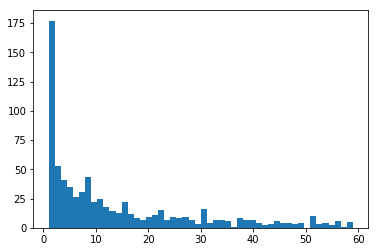

In [17]:
plt.hist([i[1] for i in e2num.most_common() if i[1] < 60], bins=50)
plt.show()

In [18]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))

weights = np.zeros((len(e2i)))

for e, ind in e2i.items():
    weights[ind] = e2num[e]
weights = np.log(weights)
weights = softmax(1 / (weights / np.min(weights)))

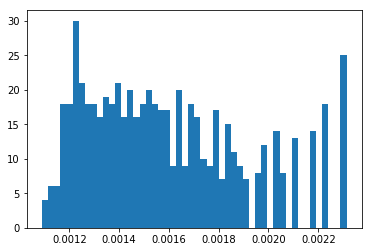

In [19]:
plt.hist(weights, bins=50)
plt.show()

In [20]:
class FasttextSet(Dataset):
    def __init__(self, cosmo):
        '''
        data - json file name
        '''
        with open(cosmo, 'r') as f:
            self.cosmo = json.load(f)
        self.cosmo, self.emojis = vectorize_all(self.cosmo)
        self.cosmo = np.array(self.cosmo)
        
        self.x = []
        self.y = []
        for vec, em in zip(self.cosmo, self.emojis):
            emjs = np.zeros(len(e2i))
            empty_flag = 0
            for e in em:
                try:
                    emjs[e2i[e]] = 1
                    empty_flag = 1
                except Exception as e:
                    continue
            if empty_flag:
                self.x.append(vec)
                self.y.append(emjs)
        self.x = np.row_stack(self.x)
        self.y = np.row_stack(self.y)
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ind):
        return torch.Tensor(self.x[ind]).long(), self.y[ind]

In [21]:
memLoader = DataLoader(FasttextSet('../data/joined-emoji-train.json'),
                       batch_size=32, shuffle=True)

In [22]:
memLoader_val = DataLoader(FasttextSet('../data/joined-emoji-val.json'),
                           batch_size=32, shuffle=True)

In [23]:
class EmojiNet(nn.Module):
    def __init__(self, ):
        super(EmojiNet, self).__init__()
        self.embs = nn.Embedding(len(vectors), embedding_dim=100, padding_idx=PAD_IDX).from_pretrained(
            torch.FloatTensor(vectors.vectors)
        )
        self.process = nn.Sequential(
            nn.Conv1d(100, 128, 15),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.05),
            nn.Conv1d(128, 128, 9),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.05),
            nn.Conv1d(128, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
        )
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, len(e2i)),            
        )
        
    def forward(self, x):
        x = self.process(self.embs(x).permute(0, 2, 1))
        x = x.view(x.shape[0], -1)
        return self.fc(x)

In [39]:
len(e2i)

624

In [25]:
simnet = EmojiNet().cuda()

In [26]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(weights).cuda())
optim = torch.optim.Adam(simnet.parameters())

In [27]:
train_losses = []

for epoch in tqdm_notebook(range(100)):
    for x, target in tqdm_notebook(memLoader, leave=False):
        x, target = x.cuda(), target.cuda()
        optim.zero_grad()
        pred = simnet(x)
        loss = criterion(pred, target.float())
        train_losses.append(loss.item())
        loss.backward()
        optim.step()


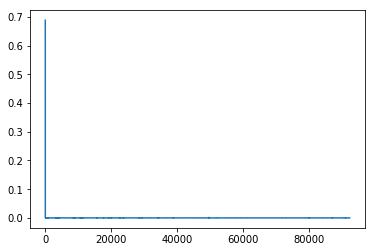

In [28]:
plt.plot(train_losses)

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_true = []
y_pred = []

for x, target in tqdm_notebook(memLoader_val):
    pred = simnet(x.cuda())
    for i, j in zip(pred.cpu().squeeze().detach().numpy(), target.detach().numpy()):
        y_pred.append(sigmoid(i))
        y_true.append(j)

y_true = np.row_stack(y_true)
y_pred = np.row_stack(y_pred)


In [30]:
y_predictions = np.argsort(y_pred)[:, -3::]
y_true_h = np.argsort(y_true)[:, -2::]

In [31]:
y_predictions.shape

(372, 3)

In [32]:
for pred, true in zip(y_predictions, y_true_h):
    print('pred -> ', ' '.join([i2e[p] for p in pred]), '\t true -> ', ' '.join([i2e[t] for t in true]))

pred ->  🙏 🙈 🏻 	 true ->  ♀ 😌
pred ->  😳 🏼 👇 	 true ->  🍚 🎉
pred ->  🎈 😍 🙏 	 true ->  💜 🏻
pred ->  ❤ 🔝 🏻 	 true ->  😜 😎
pred ->  💍 💎 🏅 	 true ->  🍉 👏
pred ->  ✨ ❤ 😍 	 true ->  😻 🏆
pred ->  💋 🙏 ❤ 	 true ->  🍚 🔥
pred ->  🙏 🏻 👆 	 true ->  🍚 😬
pred ->  ☺ 🙈 ☀ 	 true ->  🔥 👏
pred ->  😍 ☺ 🙈 	 true ->  👌 ☺
pred ->  😍 ❤ 🎾 	 true ->  👯 😕
pred ->  😜 🙈 😂 	 true ->  📝 😂
pred ->  🏼 🏻 ❤ 	 true ->  🍚 💞
pred ->  ♀ ❤ 🏼 	 true ->  🙈 🏖
pred ->  🏻 🏼 ❤ 	 true ->  🐒 🤣
pred ->  👏 🙏 ❤ 	 true ->  🙌 💋
pred ->  🙏 🏻 ❤ 	 true ->  📝 😂
pred ->  🏻 🙏 ❤ 	 true ->  😊 💃
pred ->  😍 😂 ❤ 	 true ->  ☺ 💃
pred ->  🔥 ❤ 😍 	 true ->  🍚 😍
pred ->  👋 ✅ 🏼 	 true ->  😏 👇
pred ->  😍 😄 🏼 	 true ->  🍕 🧀
pred ->  🏼 😅 🙈 	 true ->  😂 😭
pred ->  😜 🙈 😂 	 true ->  🏻 👌
pred ->  😬 🙈 ❤ 	 true ->  👌 🎧
pred ->  🏻 🙈 😂 	 true ->  ❤ 🏽
pred ->  🎊 🤔 🏼 	 true ->  🙏 🏼
pred ->  🙏 🏻 ❤ 	 true ->  🙏 👏
pred ->  😍 ❤ 😘 	 true ->  👸 😛
pred ->  👅 🙈 👟 	 true ->  🏻 🏖
pred ->  🌺 🏼 😂 	 true ->  👆 💁
pred ->  😅 ☺ 😝 	 true ->  ☺ 💆
pred ->  🙌 🙏 ❤ 	 true ->  👌 😎
pred ->  🤗

In [33]:
def test_strs(x):
    x = vectorize_text_only(x)
    if not x:
        return None
    x = torch.Tensor(x).long().unsqueeze(0)
    ans = simnet(x.cuda())
    ans = np.argsort(ans.cpu().detach().numpy())[:, -3::]
    return [i2e[i] for i in ans[0]]

In [34]:
with open('../data/joined-emoji-val.json', 'r') as f:
    val = json.load(f)


In [35]:
for text in val:
    ans = test_strs(text)
    if not isinstance(ans, type(None)):
        print(text, ' -- \t --', ans)


{'text': 'если допустить, что в среднем человек живет 80 лет, то 30 из них он проспит. #доброеутро'}  -- 	 -- ['\U0001f924', '❤', '🙏']
{'text': 'Пока самолёт только что приземлился в Минске , добавляю горячее фото с островов 😅😎🏝Чтобы завтра работалось лучше 😅💪🏻📸'}  -- 	 -- ['😍', '🏻', '✨']
{'text': 'Тот, кто любит давать советы, сам в\xa0них больше всего нуждается 😂👌🏼 Красавица 👱🏻\u200d♀️\n@annasvi____ \nКрасавчик 🍆👇🏻\n@bittuevv \nНе Серёжа 😏👇🏻 @veenolecelebreofficiel ✅Напиши слово 💥ЛЮБОВЬ🔥по буквам , так что бы никто не перебил 👍🏼 и получи лайк от Kross\n✅Подпишусь 👉🏼на обладателя 👉🏼самого смешного комментария 😂🙏🏻\n✅1.посмотри видео \n2.поставь лайк \n3.сохрани видео \n4. напиши комментарий ‼️я всё ,хочу видео привет 👋🏻 в сторис ‼️\nВыберу трёх 😁счастливчиков которым передам привет у себя в сторис 😃\n\n#любовь #love #тимати #тнт  #коррекцияфигуры #худеемклету  #дом2 #дом2новоти #blackstar #девочкиьакиедевочки #кавказ  #блондинка #егоркрид #бузова #musically #егоркрид #ольгабузова'}  --

{'text': 'Apples were reinvented since I got this 🍏-slicer! | Кто сказал, что вкусные фрукты бывают только из Тайланда? А с этой 🍎-резкой, я открыла для себя яблоки с новой стороны! 😋 #vsco #vscocam #vscofood #vscorussia #apples #яблоко #правильноепитание #веган #vegan'}  -- 	 -- ['🐔', '😍', '😂']
{'text': 'Можно ещё одно фото с моей главной Валентинкой 😍❤️\n.\nКстати, помню в школе училась когда, очень ждала этот день 🙈 не то, что сейчас 😂 тайные валентинки от поклонников, интриги и расследования и разочарования от кого и кому пришло 😂\n.\nА ещё мне очень нравилось имя Валентина. Потому что из него можно было сделать сокращённое модное Тина, на западный манер 😂 помню думала, почему я Настя, а не Мелани, или, например, Линда, ну или уж на худой конец, Элен (как В Элен и ребята)😂😂😂 да-да, Линда это вообще было мое имя мечта. Уж не знаю почему😂 но во всех чатах (в интернет кафе, помните?😂 не говорите, что нет😝), я сидела под этим именем 🙈\n.\nХотя сейчас я вполне довольна своим именем🙈 эх,

{'text': 'А вы верите в дружбу между мужчиной и женщиной?\U0001f92a😇'}  -- 	 -- ['👩', '🎂', '👧']
{'text': 'Привыкаю 🎤 #людиневерили #мнебольшенебольно #привыкаю'}  -- 	 -- ['🏻', '🙏', '❤']
{'text': 'вещали на РСН по темам недели в блогах. спасибо @gorodni4eva'}  -- 	 -- ['\U0001f924', '🏻', '😳']
{'text': 'Когда с кучей пакетов немного потерялись где-то рядом с #moscowcity 😡'}  -- 	 -- ['💪', '\U0001f924', '🏻']
{'text': '5 марта в 20:00 не пропусти наш прямой эфир с главным редактором Cosmopolitan Shopping Таней Максимовой @tati_maksimova и стилистом Катей Гуссет @katya_gousset 💫\n\nТы узнаешь о главных трендах этой весны первой, ведь мы составим модные луки из вещей от MADELEINE в прямом эфире.\nА еще Катя и Таня поделятся своими идеями подарков на 8-ое марта и расскажут как в этот день выглядеть лучше всех ;)'}  -- 	 -- ['🙈', '💫', '😬']
{'text': 'Кто-то не дождался папу, чтобы идти гулять 🙈😂😴'}  -- 	 -- ['😁', '😹', '😂']
{'text': 'Так быстро темнеет...только было солнце...вышла - и уже темно

{'text': '«Настя, ну сколько можно жрать-то, а?!» примерно каждый день я слышу этот вопрос \U0001f926🏼\u200d♀️\nНет, может и правда пора завязывать, но только не сегодня, ведь придти в Черчилль паб @churchills_pub_moscow и не заказать все и сразу - просто не возможно!\nТак вот, ловите новый обзор:\nИтак, мы заказали\n📍буратту со сладкими томатами, песто и малиновым соусом (750 р.)\n📍бифштекс из мраморной говядины с яйцом, пюре и лисичками (850 р.)\n📍тар-тар из оленины (850 р.)\n📍стейк мясника с овощами (1300 р.) - уффф, дамы, даже не пытайтесь съесть это блюдо в одного \U0001f926🏼\u200d♀️😅\n📍за кадром остался тар-тар из тунца (750 р) \U0001f924\nИ божественные десерты от шеф-повара 🍰🍮🍭\nВ общем, выносите меня семеро, потому что самостоятельно уйти было уже не просто. Атмосфера паба настолько уютная, что уходить совершенно не хочется ☺️\nДобавляйте в список must-visit мест, потому что посетить самый старинный паб Москвы просто необходимо!🙌🏻\n.\n.\n#eatwith_hm\n #vsco #vscocam #vscocamph

{'text': 'Близится самый весенний праздник - ❤ 8 Марта! \nНаши друзья-декораторы из @airbeautyballoons подобрали для вас стильные сеты к этому дню.\nПоторопитесь заказать у них оформление, ведь праздник совсем близко 🔜\n#airbeautyballoons'}  -- 	 -- ['😉', '💫', '🌴']
{'text': 'Любовь с первого взгляда @offi_hanna ❤️❤️❤️💋🔝 #Repost @pashuofficial\n・・・\n🙈🙈🙈😂😂😂💃Девочки встали с веселой ноги ☝️😂 @buzova86 в танцах с женщинами весьма опасна 🙃🙃🙃🙃 #WhitepartyBlackStar Спец вечеринка для всех наших 🙌 Каждые 3 месяца мы будем делать спец вечеринки для своих людей! ☝️☀️💯'}  -- 	 -- ['✨', '❤', '😅']
{'text': 'Мои дорогие, вы постоянно мне пишете про концерты и выступления на ваших мероприятиях. Мне очень приятно, что Вам нравится мое творчество. По вопросам концертов, гастролей, пишите и звоните моему директору @archer_music 📱 С датами реально очень сложно, но он старается всем помочь. Большой концертный тур 2018 тоже формируется #арамгдетоздесь #концерты #гастроли #ОльгаБузова #тур2018 #подзвукипоце

{'text': 'Кое кто сегодня ночью так разлёгся на Диминой подушке, что свалился и растянул себе лапу 😔 и полночи я сидела с ним, пока он шипел и хромал 😥 но судя по всему, ему значительно лучше 🙃😜 не могу смотреть, когда они болеют 😔'}  -- 	 -- ['😸', '❤', '☺']
{'text': 'Ко мне на ток-шоу приехала моя @akryyana 👯 работаем даже во время основной работы😂 И конечно же мы в одежде от @olgabuzova_design 🔝'}  -- 	 -- ['🙃', '🏻', '♀']
{'text': 'Это была любовь с первого взгляда 🐴❤️ с первого контакта и первого прикосновения 🐎🙌🏻 спасибо большое моей @bulavina за эту невероятную фотосессию...Я как будто, окунулась в другой мир...в мир, где нет зависти и лжи, где всё чисто и прозрачно...Волшебное место, потрясающие воспоминания😻 @bulavina -фото; @koshkinaolga_ -мейк, @alinayartseva - прическа 💋'}  -- 	 -- ['🙈', '😧', '❤']
{'text': "Поделитесь, мои хорошие, где берете энергию? Как всё успеваете и при этом не падаете без сил в конце длинного дня? \U0001f937🏻\u200d♀\nЯ бы не выдержала такого графика, ес

{'text': 'Тут был пост о грядущем марафоне на 🌰 \nНо так как он уже идёт, отмечу, что у нас есть аккаунт:\n@telovod , в котором каждый месяц мы проводим марафоны стройности!) а ещё  у нас можно купить мои любимые фитнес-резинки и экспандеры 😘'}  -- 	 -- ['🏻', '🙏', '😍']
{'text': 'Почти пятиминутный дневник невесты 👰🏻 ⠀\n\nДомашний уход для лица @foreo_ru + @ultraceuticals_russia 🌿 Что помогает быстро похудеть? Как быстро загореть? И где быстро пошить платье? 💃🏽\n⠀\n\nКак же я рада, что записывала тот суетной бьюти-день накануне свадьбы. Я смотрю в свои ошалелые глаза и вспоминаю, какую бурю эмоций испытывала внутри из-за предстоящего торжества. Думаю,  примерно у каждой невесты такие дикие глаза :)) ⠀\n\nЗаписала вам все этапы финальной подготовки к свадебной красоте. Пишите вопросы 😘\n⠀\nhttps://bit.ly/2LK3Gpc 🎞: #FOREO #LUNA2 #ultraceuticals @mai_mai_bridal @bronzeglow_beautyexpress #weddingday #weddingpreparations #beautyroutine #эндосфера #mkd_бьютисреда'}  -- 	 -- ['✨', '😉', '👐']
{

{'text': '❗️Смотреть до конца❗️\nУ Страха-Глаза Велики,а у Ревности-ещё и НАВЫКАТЕ. \U0001f923😳 Самый ревнивый 😅👉🏼 @narek_araikovich \U0001f6d1Отмечай своего ревнивца 😂☝🏼 ✅первым 💯 комментариям лайк от Kross ✌🏻\n✅1.посмотри видео\n2.поставь лайк \n3.сохрани видео \n4. Оставь комментарий ‼️я всё,хочу видео привет 👋🏻 в сторис ‼️😱\n✅Обязательно выполни все пункты , выберу 3 счастливчиков , которым передам привет , у себя в сторис 😁👍🏼 #оружие #отношения #дневникхача #кавказ #дом2 #дом2новости #трюк #sexy #девочкитакиедевочки #ржака #юмор #бузова #диета #пп #рецепты #musically #music'}  -- 	 -- ['😂', '🏻', '🏼']
{'text': 'Доброе утро, Cosmo-girl! Все мы наслышаны о пользе завтрака 😋 и стараемся его не пропускать! Делись с нами в комментариях, что ты сегодня приготовила, а потом читай, что приготовили звезды в нашем Cosmo-гороскопе 💫 \n@cosmoru_pisces – РЫБЫ ♓\u2028@cosmoru_taurus – ТЕЛЕЦ ♉ @cosmoru_aquarius – ВОДОЛЕЙ ♒\u2028@cosmoru_sagittarius – СТРЕЛЕЦ ♐\u2028@cosmoru_scorpio – СКОРПИОН ♏ @

{'text': 'Конечно, не так технично, как у @t_killah, но концовка вытянула 🏋🏽\u200d♀️'}  -- 	 -- ['\U0001f926', '👐', '😂']
{'text': 'Когда ты очень голоден🙈🐷 #vsco #vscocam #vscogram #vscogood #vscofood #vscomoscow #vscorussia #food #foodporn #foodgram #eatwith_hm'}  -- 	 -- ['😭', '💔', '😂']
{'text': '🙈Я снова не смогла выбрать:))) 🙌🏻Организовали себе съемку у океана у ооочень крутого фотографа😍 К которой давно мечтала попасть🙌🏻 По этим бекстейдж-фото я поняла, что в эту беременность у меня совершенно другой живот😳🙈 И что я хочу брекеты ещё😂\U0001f926🏻\u200d♀️ .\n💕Меня недавно под фото спросили, какую я себе раньше представляла свою жизнь, своего мужа, свою семью...🤔\nЯ думала-думала и поняла, что не представляла\U0001f937🏻\u200d♀️\n🙈Точно могу сказать, что я всегда знала, что у моего мужа будет красивое тело😂 Мне всегда это нравилось😂😂 А о детях, семье особенно и не думала:)\n💖А сейчас смотрю на свою семьи и понимаю, что она почти идеальная 🙈 Маленькой булочки на руках ещё не хватает:)) 

{'text': 'Я честно говоря не знаю, кому-то вообще актуальна тема питания в разгар таких праздников?😂🙈 но я все же попробую. \nПо моим сторисам, кто смотрит, уже поняли, что перед отпуском я решила немного подсбросить, и для этого на 2,5 недели перехожу немного на другую схему питания\nБелково-углеводное чередование - сокращённо буч. Это уже не первый мой опыт, поэтому писать супер подробно не буду, лучше загуглить☺️ или ещё много писанины по тегу #agolovinova_буч ☺️\nНу если очень кратко, то как и понятно из названия это чередование белковых и углеводных дней.\nПочему именно так? Потому что пп я и так придерживаюсь. Уже больше полугода мы с мужем пользуемся сервисом по доставке готового питания @growfoodrus и все замечательно, но к сожалению буч меню у них пока нет 😉 поэтому на время вернусь к плите, там женщине и место😂\nМой организм уже привычен к пп. А к чередованию нет☺️ на это и ставка - немного расшевелить и сдвинуться с плато по весу ☺️ надеюсь понятно объяснила ☺️\nПо итогу. У 

{'text': 'В общем, самое главное перевезли 😂 я не я без капучино с утра☕️\nZyuzino district хэллоу 😜\nСегодня ночуем на новой квартире🙈 на надувном матрасе перед камином ✨ романтика 😂 муж говорит купим шампусик, закажем пиццу 😜 а ещё сейчас едем в магазин по мелочи и за пеной для ванной ☁️ кто не в курсе, в старой квартире у нас душевая и про то как мы там купаемся с Лиськой - лучше не говорить 🙈 поэтому вечером мы в первый торжественный заплыв с уточками и свинкой пеппой 😂\nВот такие грандиозные планы ☺️ может в эфир выйдем. А может и нет \U0001f937🏼\u200d♀️😂\nИ вечером планирую пост про реснички и уход за лицом 🤗😜 так что ждите 😜 и не грустите, лето когда-нибудь будет 🙈😂 но это не точно 😂'}  -- 	 -- ['\U0001f937', '♀', '😂']
{'text': 'Приехала и сразу гол 🔝👏👏👏 переживаю🙏'}  -- 	 -- ['❤', '\U0001f926', '🏻']
{'text': 'Мы вчера целый день прокатались по делам, закупкам тканей и тд. Последние выходные до нового года мы провели, блин, как обычно 😂🙈 за подарками судя по всему поедем на неде

{'text': 'Можно ещё эту загружу😈😊😹\n___\nОбещала подсказать, что лучше учить к ЕГЭ и дек.соч ЛЕТОМ🌲 П.с. Сразу говорю, исхожу из своих предметов: Русский,Матем профиль и база, англ, обществознание.\n\n1️⃣англ! Вот на него потратьте лето. Это тот предмет, на который не нужно много сил, а нужна только практика и время. \nДелайте чтение из Решу ЕГЭ, у кого много амбиций и кто хочет сдать идеально - по 2 полных чтения в день. Выписывайте все неизвестные слова на карточки, учите. Как это делать подробнее в тэге, фотка с карточками.\nСмотрите сериал на англ с англ(!) субтирами. В Директ могу кинуть ссылку на идеальный сайт. \nСкачайте uk radios ,слушайте, практикуйте аудирование таким образом. + в конце практически каждого учебника (но я учила по Кузнецовой grammar&vocabulary) есть таблица со словообразованием. Постарайтесь выучить её за лето. На самом деле на ней держится 70%егэ по англ. Если будете знать все эти слова и из однокоренные, то все сдадите просто прекрасно) \n2️⃣Русский. Тут ле

{'text': 'Июнь, жара, плавится даже асфальт… Ныряй вместе с @cosmopolitan_russia в освежающую подводную фотоисторию с самыми горячими российскими звездами @starshenbaum @actorsashapetrov @rinal_mukhametov и @yura.borisov. Бирюзовая вода искажает реальность… или это #200ДнейДоВторжения? Пора вместе с главным редактором Cosmopolitan @alionapeneva_cosmo выяснить, что нам готовит очередное инопланетное вторжение. \nПолное видео смотрите по ссылке в профиле↖️\n#Вторжение - в кино с 1 января 2020 👽@invasion_film \n#ЖдитеВторжение #Cosmopolitan25'}  -- 	 -- ['👇', '🏼', '♀']
{'text': '#Анапа , #Невинномысск , спасибо вам за такие крутые сольники! Уже скучаю по вашим тёплым краям ❤️ Ну а мы полетели дальше ✈️'}  -- 	 -- ['😂', '\U0001f924', '❤']
{'text': 'В Москве 30 декабря. Самое время достать из шкафа летние шорты. 🌦'}  -- 	 -- ['🏻', '👍', '❤']
{'text': 'Не самое лучшее наше фото, но по крайней мере мы здесь все вместе 👪🌴🌞\n‼️КИЕВ!!!)) Вы помните, что уже послезавтра (в воскресенье, 18го числа)

{'text': 'ТОП 10 ПОДАРКОВ КО ДНЮ СВЯТОГО ВАЛЕНТИНА ❤️\nᅠ\nСкоро приближается самый романтичный праздник в году, поэтому делюсь с вами подборкой подарков для влюблённых пар 💑 Не забывайте сохранять:\nᅠ\n1.Альбом с вашими фотографиями, сделанный своими руками. В прошлом году я распечатала для Стаса 50 наших фотографий, вклеила в красивый альбом для скетчей, а на оставшееся место написала настоящий рассказ о наших отношениях.\n2.Выходные в загородном отеле на двоих. В этом году 14 февраля выпадает на четверг, а значит уже на следующий день можно ехать загород. А ещё многие отели предлагают специальные романтические предложения для пар. Я бы рассмотрела отели Мистраль и Яхонты.\n3.Спа-программа для двоих. Что может быть лучше свидания в джакузи, релакс-массажа и шоколадной терапии? Именно такие программы для двоих сейчас активно предлагают спа-салоны. Надо брать!\n4.Свидание в ресторане в темноте. Я была в таком однажды в Москве. Вокруг темно, вы не видите где находитесь и не знаете что ед

In [36]:
test_strs({'text': 'Дональд трамп и путин обьявили о помолвке'})

['💘', '\U0001f937', '👧']

In [37]:
test_strs({'text':
           'Вот такие дифирамбы поют Сашка поклонники 🤔А вы что скажете? Черно по делу выступает на Лобном или не всегда?'})

['🙌', '😂', '🙈']

In [38]:
simnet.cpu()
torch.save(simnet.state_dict(), '../models/emojinet.state_dict')

In [63]:
import similarity as sim

In [69]:
sim.process_str({'text':
                 ' поклонники 🤔всегда?'})